In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [70]:
RESULTS_CSV = "path/to/results.csv"

In [72]:
df = pd.read_csv(RESULTS_CSV)

/var/folders/pc/y73q1gz157177nk6pl_7tpf40000gq/T/ipykernel_17674/244144045.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RESULTS_CSV)


In [73]:
# Only those where we have results for both 
df = df[df["successful_generation"]==1]
df = df[df["constrained_overhead_mean"].notnull()]

In [77]:
df["context_size"] = df["prefix_size"] + df["suffix_size"]
df = df[df["context_size"] != 0]

In [78]:
df = df.sort_values(by="context_size")

In [79]:
def plot_with_trend(label, x, y, args = {}, lineargs = {}, lineargs2 = {}):
    plt.scatter(x, y, label=label, **args)
    # Lines are unhelpful for visualization due to the distortion of the log-log plot
    # And really, the data speaks for itself.
    # However, we do want the r^2 for the linear correlation
    
    #z = np.polyfit(np.log10(x), np.log10(y), 1)
    #p = np.poly1d(z)
    #plt.plot(x, 10**p(np.log10(x)), label=f"{10**z[1]:#.3g} x^{z[0]:#.3g}", **lineargs)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    print(z)
    print(r2_score(y, p(x)))
    #plt.plot(x, p(x), label=f"{z[0]:.3g}x + {z[1]:.3g}", **lineargs2)
    plt.loglog()
    return z

In [80]:
# Unconstrained checking overhead is per-char while constrained is per-token
# The following fixes this for fair comparison
df["total_unconstrained_overhead_time"] = df["unconstrained_checking_overhead_mean"] * df["unconstrained_checking_overhead_num"]
df["unconstrained_checking_per_token"] = df["total_unconstrained_overhead_time"] / df["num_unconstrained_tokens"]

[ 0.00037038 -0.17720788]
0.5442349438991926
[9.54087389e-06 4.52845633e+00]
0.004225620958034804


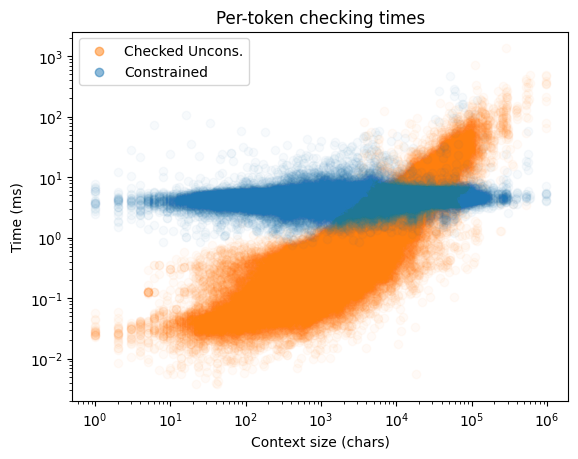

In [81]:
z2 = plot_with_trend("Checked Uncons.", df["context_size"], df["unconstrained_checking_per_token"]*1000, {"alpha": 0.03, "color": "C1"}, {"color":"orange"}, {"color": "red"})
z1 = plot_with_trend("Constrained", df["context_size"], df["constrained_overhead_mean"]*1000, {"color": "C0", "alpha": 0.03}, {"color":"blue"}, {"color": "purple"})
plt.title("Per-token checking times")
plt.xlabel("Context size (chars)")
plt.ylabel("Time (ms)")
for lh in plt.legend().legend_handles:
    lh.set_alpha(0.5)
plt.savefig("per_token_times.png", dpi=500)

[  0.28292636 270.09888507]
0.7293869015310661


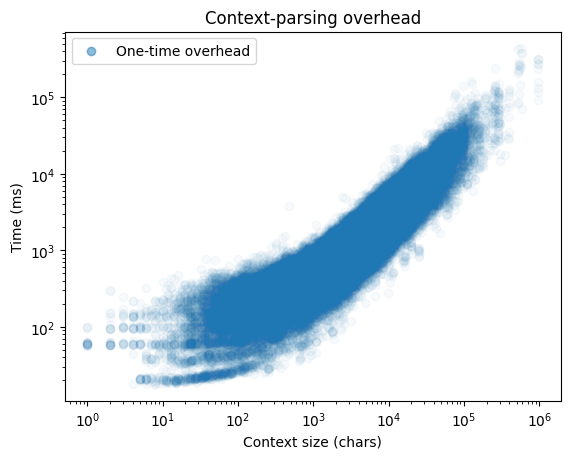

In [82]:
plot_with_trend("One-time overhead", df["context_size"], df["pre_time"]*1000, {"alpha":0.03}, {"color":"blue"})
for lh in plt.legend().legend_handles:
    lh.set_alpha(0.5)
plt.title("Context-parsing overhead")
plt.xlabel("Context size (chars)")
plt.ylabel("Time (ms)")
plt.savefig("context_parsing_overhead.png", dpi=500)